![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 3 - Optimization Methods </center>
### <center> Data Pre-processing and Weights Initialization</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/03_OptimizationMethods/MainInitialization.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})
np.random.seed(1)

###  What we have so far:
This part will grow so we will move this to its own module

In [18]:
class ReLULayer:
    def __init__(self):
        self.dParams = {}
        self.dGrads  = {}
    
    def Forward(self, mX):
        self.mX = mX                 #-- store for Backward
        mZ      = np.maximum(mX, 0)
        
        return mZ
    
    def Backward(self, mDz):
        mX    = self.mX
        mMask = (mX > 0).astype(np.float32)
        mDx   = mDz * mMask
                
        return mDx

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def CrossEntropyLoss(vY, mZ):
    '''
    Returns both the loss and the gradient w.r.t the input (mZ)
    '''
    N      = len(vY)
    mHatY  = np.exp(mZ)
    mHatY /= np.sum(mHatY, axis=0)
    loss   = -np.log(mHatY[vY,range(N)]).mean()
    
    mDz               = mHatY
    mDz[vY,range(N)] -= 1
    mDz              /= N
    
    return loss, mDz

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
class Model:
    def __init__(self, lLayers):
        self.lLayers = lLayers

    def Forward(self, mX):
        for oLayer in self.lLayers:
            mX = oLayer.Forward(mX)
        return mX

    def Backward(self, mDz):
        for oLayer in reversed(self.lLayers):
            mDz = oLayer.Backward(mDz)

#### Adding Kaiming (and Xavier) initialization to the linear layer:
$$\boldsymbol{W}\left[i,j\right]=\mathcal{N}\left(0,\sigma_w^2\right)$$
where:
* Xavier - $\sigma_{w}^{2}=\frac{1}{d}$
* Kaiming - $\sigma_{w}^{2}=\frac{2}{d}$
* $d$ is the input dimension.

In [19]:
class LinearLayer:
    def __init__(self, dIn, dOut, init='Kaiming'):
        if   init == 'Kaiming': mW = np.random.randn(dOut, dIn) * np.sqrt(2 / dIn)
        elif init == 'Xavier':  mW = np.random.randn(dOut, dIn) * np.sqrt(1 / dIn)
        else:                   mW = np.random.randn(dOut, dIn) / dIn #-- this is how we initialize previously
        
        vB = np.zeros(dOut)

        self.dParams = {'mW' : mW,   'vB': vB}
        self.dGrads  = {'mW' : None, 'vB' : None}

    def Forward(self, mX):
        mW      = self.dParams['mW']
        vB      = self.dParams['vB']
        self.mX = mX                   #-- store for Backward
        mZ      = mW @ mX + vB[:,None]

        return mZ

    def Backward(self, mDz):
        mW  = self.dParams['mW']
        mX  = self.mX
        
        vDb = mDz.sum(1)
        mDw = mDz  @ mX.T
        mDx = mW.T @ mDz
        
        self.dGrads['vB'] = vDb
        self.dGrads['mW'] = mDw

        return mDx


### Get Fashion MNIST dataset

In [5]:
import torchvision
import torchvision.transforms as transforms

#-- For now, we use PyTorch just to get the data:
oTorchTrainSet = torchvision.datasets.FashionMNIST(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
# oTorchTestSet  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

lClasses = oTorchTrainSet.classes
mX       = oTorchTrainSet.data.view(-1,784).numpy() / 255
vY       = oTorchTrainSet.targets.numpy()
mX.shape, vY.shape

((60000, 784), (60000,))

#### Classes:

In [6]:
list(zip(range(10), lClasses))

[(0, 'T-shirt/top'),
 (1, 'Trouser'),
 (2, 'Pullover'),
 (3, 'Dress'),
 (4, 'Coat'),
 (5, 'Sandal'),
 (6, 'Shirt'),
 (7, 'Sneaker'),
 (8, 'Bag'),
 (9, 'Ankle boot')]

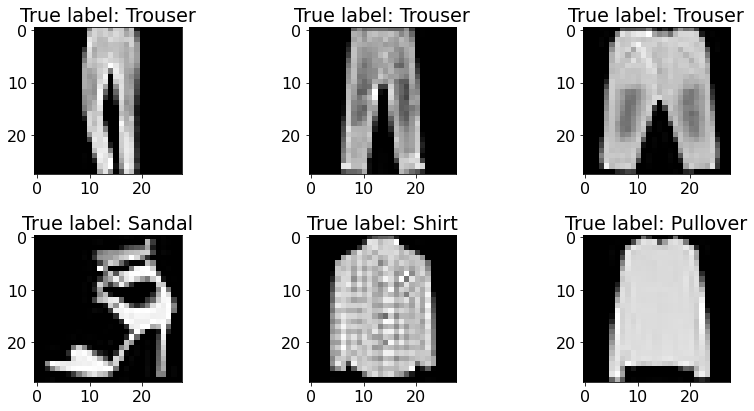

In [7]:
#-- Plot a few examples:
N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(12, 6))
for ax in fig.axes:
    idx = np.random.randint(N)
    ax.imshow   (np.reshape(mX[idx,:], (28, 28)), cmap='gray')
    ax.set_title(f'True label: {lClasses[vY[idx]]}')
    
plt.tight_layout()
plt.show()

###  Split to train and validation:

In [8]:
from sklearn.model_selection import train_test_split

Ntrain = 55000
Nval   = 5000
mTrainX, mValX, vTrainY, vValY = train_test_split(mX, vY, train_size=Ntrain, test_size=Nval)

(mTrainX.shape, 
vTrainY.shape, 
mValX.shape,  
vValY.shape)

((55000, 784), (55000,), (5000, 784), (5000,))

### Define the training loop:

In [9]:
import time

#-- Classification accuracy:
def Accuracy(mScore, vY):
    vHatY    = np.argmax(mScore, axis=0)
    accuracy = (vHatY == vY).mean()
    return accuracy
    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def TrainEpoch(oModel, mX, vY, learningRate):
    #-- Forward:
    mZ        = oModel.Forward(mX)
    loss, mDz = CrossEntropyLoss(vY, mZ)

    #-- Backward:
    oModel.Backward(mDz)

    #-- Update parameters (vanilla gradient descnet)
    for oLayer in oModel.lLayers:
        for sParam in oLayer.dGrads:
            oLayer.dParams[sParam] -= learningRate * oLayer.dGrads[sParam]
              
    #-- Check accuracy:
    acc = Accuracy(mZ, vY)
            
    return loss, acc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def ValidationEpoch(oModel, mX, vY):
    #-- Forward:
    mZ      = oModel.Forward(mX)
    loss, _ = CrossEntropyLoss(vY, mZ)
    acc     = Accuracy(mZ, vY)
    
    return loss, acc

In [10]:
def TrainModel(oModel, mTrainX, vTrainY, mValX, vValY, numEpochs, learningRate):
    lTrainLoss = []
    lValLoss   = []
    lTrainAcc  = []
    lValAcc    = []
    for epoch in range(numEpochs):
        startTime           = time.time()
        trainLoss, trainAcc = TrainEpoch     (oModel, mTrainX, vTrainY, learningRate) #-- train
        valLoss,   valAcc   = ValidationEpoch(oModel, mValX,   vValY)                 #-- validation
        endTime             = time.time()

        #-- Display:
        print('Epoch '              f'{epoch:3d}:',     end='')
        print(' | Train loss: '     f'{trainLoss:.5f}', end='')
        print(' | Val loss: '       f'{valLoss:.5f}',   end='')
        print(' | Train Accuracy: ' f'{trainAcc:2.4f}', end='')
        print(' | Val Accuracy: '   f'{valAcc:2.4f}',   end='')
        print(' | epoch time: '     f'{(endTime-startTime):3.3f} |')
        
        lTrainLoss.append(trainLoss)
        lValLoss  .append(valLoss  )
        lTrainAcc .append(trainAcc )
        lValAcc   .append(valAcc   )
    
    return lTrainLoss, lValLoss, lTrainAcc, lValAcc

#### Train <u>without</u> normalizing and initialization:

In [17]:
oModel = Model([
        LinearLayer(784, 200, init=None), ReLULayer(),
        LinearLayer(200, 10,  init=None),
])

nEpochs = 30
lr      = 2e-1

_, lValLossV1, _, lValAccV1 = TrainModel(oModel, mTrainX.T, vTrainY, mValX.T, vValY, nEpochs, lr)

Epoch   0: | Train loss: 2.30246 | Val loss: 2.30118 | Train Accuracy: 0.1417 | Val Accuracy: 0.2620 | epoch time: 0.921 |
Epoch   1: | Train loss: 2.30120 | Val loss: 2.29986 | Train Accuracy: 0.2621 | Val Accuracy: 0.3414 | epoch time: 0.844 |
Epoch   2: | Train loss: 2.29989 | Val loss: 2.29824 | Train Accuracy: 0.3399 | Val Accuracy: 0.3874 | epoch time: 0.856 |
Epoch   3: | Train loss: 2.29828 | Val loss: 2.29617 | Train Accuracy: 0.3833 | Val Accuracy: 0.3878 | epoch time: 0.885 |
Epoch   4: | Train loss: 2.29623 | Val loss: 2.29347 | Train Accuracy: 0.3887 | Val Accuracy: 0.3908 | epoch time: 0.870 |
Epoch   5: | Train loss: 2.29356 | Val loss: 2.28988 | Train Accuracy: 0.3887 | Val Accuracy: 0.3780 | epoch time: 0.794 |
Epoch   6: | Train loss: 2.29001 | Val loss: 2.28503 | Train Accuracy: 0.3805 | Val Accuracy: 0.3690 | epoch time: 0.863 |
Epoch   7: | Train loss: 2.28522 | Val loss: 2.27846 | Train Accuracy: 0.3731 | Val Accuracy: 0.3538 | epoch time: 0.900 |
Epoch   8: | Tra

####  Normalize data:
Based on the training data

In [36]:
vMean = mTrainX.mean(0)
vStd  = mTrainX.std (0)

mTrainX -= vMean
mTrainX /= vStd
mValX   -= vMean
mValX   /= vStd

#### Train <u>with</u> normalizing and initialization:

In [38]:
oModel = Model([
        LinearLayer(784, 200, init='Kaiming'),
        ReLULayer(),
        LinearLayer(200, 10,  init='Xavier'),   
])

nEpochs = 30
lr      = 2e-1

_, lValLossV2, _, lValAccV2 = TrainModel(oModel, mTrainX.T, vTrainY, mValX.T, vValY, nEpochs, lr)

Epoch   0: | Train loss: 3.01333 | Val loss: 1.28364 | Train Accuracy: 0.0627 | Val Accuracy: 0.5510 | epoch time: 0.936 |
Epoch   1: | Train loss: 1.29452 | Val loss: 1.07734 | Train Accuracy: 0.5485 | Val Accuracy: 0.6400 | epoch time: 1.054 |
Epoch   2: | Train loss: 1.07722 | Val loss: 1.03287 | Train Accuracy: 0.6360 | Val Accuracy: 0.6270 | epoch time: 0.958 |
Epoch   3: | Train loss: 1.02780 | Val loss: 0.98105 | Train Accuracy: 0.6340 | Val Accuracy: 0.6626 | epoch time: 0.921 |
Epoch   4: | Train loss: 0.97354 | Val loss: 0.97650 | Train Accuracy: 0.6636 | Val Accuracy: 0.6612 | epoch time: 0.963 |
Epoch   5: | Train loss: 0.95887 | Val loss: 0.87159 | Train Accuracy: 0.6661 | Val Accuracy: 0.7018 | epoch time: 1.003 |
Epoch   6: | Train loss: 0.86042 | Val loss: 0.86120 | Train Accuracy: 0.7074 | Val Accuracy: 0.7102 | epoch time: 1.007 |
Epoch   7: | Train loss: 0.83610 | Val loss: 0.77466 | Train Accuracy: 0.7129 | Val Accuracy: 0.7360 | epoch time: 0.970 |
Epoch   8: | Tra

### Compare the two configurations:

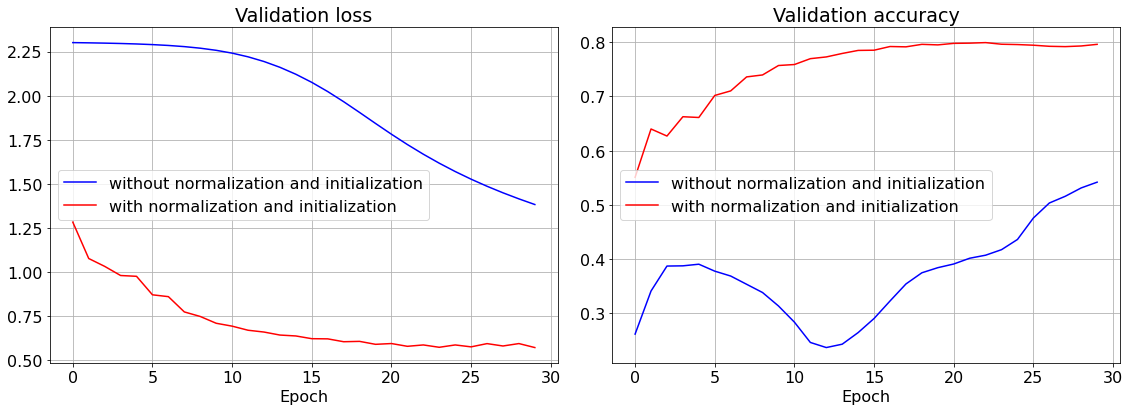

In [40]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot   (lValLossV1, 'b', label='without normalization and initialization')
plt.plot   (lValLossV2, 'r', label='with normalization and initialization')
plt.title  ('Validation loss')
plt.xlabel ('Epoch')
plt.grid   ()
plt.legend ()

plt.subplot(1,2,2)
plt.plot   (lValAccV1, 'b', label='without normalization and initialization')
plt.plot   (lValAccV2, 'r', label='with normalization and initialization')
plt.title  ('Validation accuracy')
plt.xlabel ('Epoch')
plt.grid   ()
plt.legend ()

plt.tight_layout()
plt.show()

### Exercise
Implement the `CountParameters` function
* Input: A model.
* Output: The number of parameters in the model.

In [30]:
def CountParameters(oModel):
    ???

    return nParams

In [31]:
oModel = Model([
        LinearLayer(784, 200, init=None), ReLULayer(),
        LinearLayer(200, 10,  init=None),
])

CountParameters(oModel)

Object `?` not found.


159010

In [ ]:
# def CountParameters(oModel):
#     nParams = 0
#     for oLayer in oModel.lLayers:
#         for key in oLayer.dParams:
#             nParams += oLayer.dParams[key].size()

#     return nParams